# DataLab Cup 2: CNN for Object Detection

## Dataset: PASCAL VOC2007

In [1]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

## Processed data format

In [2]:
training_data_file = open("./pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


In [3]:
import tensorflow as tf
import numpy as np
import os
import shutil
from data_aug.data_aug import *
from data_aug.bbox_util import *
from tqdm import tqdm
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2

## Hyperparameters

In [4]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './pascal_voc_training_data.txt'
IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'

# combined data path/ combined image directory
COM_DATA_PATH = './pascal_voc_training_data_combined.txt'
COM_IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages_combined/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 40

## Check class object numbers

In [5]:
images = [] # [000005.jpg, 000007.jpg, ...] 共4974張
records = [] # [[263,211,324,339,8,165,264,253,372,8], [...], ...]
num_class = [] # [5,1,...]每張圖有多少個class，為了下方擴增dataset時加速。

with open(DATA_PATH, 'r') as f:
    for line in f:
        tokens = line.split()
        images.append(tokens[0])
        # 每筆record放 5*物件個數
        record = list(map(float, tokens[1:])) # [xmin, ymin, xmax, ymax, class] = [263,211,324,339,8, ...] 
    
        # 每筆record最多只塞 MAX_OBJECTS_PER_IMAGE個物件
        if len(record) > MAX_OBJECTS_PER_IMAGE*5:
            record = record[:MAX_OBJECTS_PER_IMAGE*5] 
        records.append(record)
        num_class.append(len(record) // 5)

# 把每筆record(一維)拆成一個一個的物件框框(二維) dim: row=n/5, col=5
# record = [1,2,3,4,5,6,7,8,9,10]
# box = [[1, 2, 3, 4, 5],
#        [6, 7, 8, 9,10]]

boxes_list = []
for record in records:
    boxes = np.array(record)
    boxes = boxes.reshape((-1, 5))
    boxes_list.append(boxes)
    
image2boxes = dict(zip(images, boxes_list))

# classes in record in records
# classes = [[8,8,8],[6]]

classes = []
for record in records:
    record_class = []
    for i in range(4, len(record), 5):
        record_class.append(int(record[i]))
    classes.append(record_class)

# print(len(classes)) # 4974
        
# 計算每個class的數量 
class_cnt = np.zeros(NUM_CLASSES, int)
for record_class in classes: 
    for c in record_class:
        class_cnt[c] += 1
    
for i, num in enumerate(class_cnt):
    print(f'{i:2d}) {classes_name[i]:12}: {num}')

 0) aeroplane   : 331
 1) bicycle     : 412
 2) bird        : 577
 3) boat        : 398
 4) bottle      : 612
 5) bus         : 271
 6) car         : 1634
 7) cat         : 389
 8) chair       : 1423
 9) cow         : 356
10) diningtable : 309
11) dog         : 536
12) horse       : 403
13) motorbike   : 387
14) person      : 5318
15) pottedplant : 603
16) sheep       : 353
17) sofa        : 419
18) train       : 328
19) tvmonitor   : 366


In [19]:
combined_images = []
class_cnt = np.zeros(NUM_CLASSES, int) # index:0-19 value: # of class
num_image = len(images) # 4974
image_no = np.zeros(num_image, int)

# 先將原本的dataset放進combined dataset
# 並計算對應的各class數目
for i in range(num_image):
    record_class = classes[i]
    combined_images.append(f'{image_no[i]}-{images[i]}')
    image_no[i] += 1
    for c in record_class:
        class_cnt[c] += 1
        
_MIN = 5318

# 先看圖片所含的各個class是否都超過_MIN
# 如果其中有一個class不到_MIN我就加進去並更新class_cnt
# It turns out that person, car and chair are still imbalanced.
# while True:
#     for i, v in enumerate(classes):
#         s = set(v)
#         for c in s:
#             if class_cnt[c] < _MIN:
#                 combined_images.append(f'{image_no[c]}-{images[i]}')
#                 image_no += 1
#                 for each_c in v:
#                     class_cnt[each_c] += 1
#     if (class_cnt >= _MIN).all():
#         break

# tag = np.zeros(num_image, int)
# while True:
#     for i, v in enumerate(classes): # v = [8,8,8,8,8]
#         s = set(v)
#         for c in s:
#             if tag[i] or class_cnt[c] >= _MIN:
#                 tag[i] = 1
#                 continue
#             else:
#                 combined_images.append(f'{image_no[c]}-{images[i]}')
#                 image_no += 1
#                 for each_c in v:
#                     class_cnt[each_c] += 1
#     if (class_cnt >= _MIN).all():
#         break

# 先按照每張圖片所包含的class數量排序，並維護好index。
# 再依序看每張圖片所含的各個class是否有任一個超過_MIN。
# 若有，則不加入dataset，並上tag，未來也不加入。
# 否則，加入combined並更新class_cnt。

indexed_list = list(enumerate(num_class))
sorted_indices = sorted(indexed_list, key=lambda x: x[1], reverse=True)
sorted_indices = [index for index, value in sorted_indices]

tag = np.zeros(num_image, int)
while True:
    for i in sorted_indices:
        if tag[i]:
            continue
        record_class = classes[i]
        if np.any(class_cnt[record_class] >= _MIN): # 這張圖片其中一個class已經超過_MIN
            tag[i] = 1 # 未來不再看這張圖片
            continue
        else:
            combined_images.append(f'{image_no[i]}-{images[i]}')
            image_no[i] += 1
            for c in record_class:
                class_cnt[c] += 1
                    
    if np.all(class_cnt >= _MIN):
        break
        
for i, num in enumerate(class_cnt):
    print(f'{i:2d}) {classes_name[i]:12}: {num}')
    
# print(combined_images[0])

 0) aeroplane   : 5318
 1) bicycle     : 5318
 2) bird        : 5319
 3) boat        : 5318
 4) bottle      : 5325
 5) bus         : 5322
 6) car         : 5318
 7) cat         : 5319
 8) chair       : 5323
 9) cow         : 5319
10) diningtable : 5318
11) dog         : 5318
12) horse       : 5318
13) motorbike   : 5318
14) person      : 5318
15) pottedplant : 5322
16) sheep       : 5318
17) sofa        : 5319
18) train       : 5319
19) tvmonitor   : 5319


In [20]:
def gen_combined_dataset():
    if os.path.exists(COM_IMAGE_DIR):
        shutil.rmtree(COM_IMAGE_DIR)

    if not os.path.exists(COM_IMAGE_DIR):
        os.mkdir(COM_IMAGE_DIR)

    with open(COM_DATA_PATH, 'w') as f:
        np.random.seed(514)
        trans = Sequence([# RandomRotate(10), 
                          # RandomTranslate(0.2), 
                          RandomHSV(20, 20, 20), 
                          RandomHorizontalFlip(0.1), 
                          RandomScale(0.15), 
                          RandomShear(0.15)])

        for name in combined_images: # 0-00005.jpg
            no, namenum = name.split('-')
            
            # './VOCdevkit_train/VOC2007/JPEGImages/' + 00005
            image_file = tf.io.read_file(os.path.join(IMAGE_DIR, namenum))
            
            image = tf.io.decode_jpeg(image_file, channels=3)
            
            bboxes = image2boxes.get(namenum)
            
            # 只對新加入的圖片進行
            if no != '0':
                # ori_shape = image.shape
                image, bboxes = trans(image.numpy().copy(), bboxes.copy())
                # if image.shape != ori_shape:
                    # print("After trans shape:", image.shape)
            
            # 將轉換後的image encode並寫入combined image directory (COM_IMAGE_DIR)
            image = tf.io.encode_jpeg(image)
            tf.io.write_file(os.path.join(COM_IMAGE_DIR, name), image)

            # 寫新的圖片檔名和 bounding box 進 combined data path (COM_DATA_PATH)
            new_record = name + ' '
            box_info = []
            for box in bboxes:
                for b in box:
                    box_info.append(str(b))
            new_record += ' '.join(box_info)
            new_record += '\n'
            f.write(new_record)

#             buff_list = [name] + [str(int(b)) for box in bboxes for b in box]
#             f.write(' '.join(buff_list) + '\n')

In [21]:
augment = True
if augment:
    gen_combined_dataset()

## Dataset Loader

In [22]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(COM_DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(COM_IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

## Pretrained model + YOLO

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [23]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [24]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

basemodel = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=img_inputs)
basemodel.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_208 (Conv2D)            (None, 223, 223, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_208 (Batch  (None, 223, 223, 32  96         ['conv2d_208[0][0]']             
 Normalization)                 )                                               

                                                                                                  
 conv2d_218 (Conv2D)            (None, 53, 53, 96)   82944       ['activation_212[0][0]']         
                                                                                                  
 conv2d_219 (Conv2D)            (None, 53, 53, 64)   12288       ['average_pooling2d_1[0][0]']    
                                                                                                  
 batch_normalization_213 (Batch  (None, 53, 53, 96)  288         ['conv2d_213[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_215 (Batch  (None, 53, 53, 64)  192         ['conv2d_215[0][0]']             
 Normalization)                                                                                   
          

 conv2d_229 (Conv2D)            (None, 53, 53, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 batch_normalization_229 (Batch  (None, 53, 53, 32)  96          ['conv2d_229[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_224 (Activation)    (None, 53, 53, 32)   0           ['batch_normalization_229[0][0]']
                                                                                                  
 conv2d_227 (Conv2D)            (None, 53, 53, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_230 (Conv2D)            (None, 53, 53, 48)   13824       ['activation_224[0][0]']         
          

 batch_normalization_234 (Batch  (None, 53, 53, 32)  96          ['conv2d_234[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_237 (Batch  (None, 53, 53, 64)  192         ['conv2d_237[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_227 (Activation)    (None, 53, 53, 32)   0           ['batch_normalization_232[0][0]']
                                                                                                  
 activation_229 (Activation)    (None, 53, 53, 32)   0           ['batch_normalization_234[0][0]']
                                                                                                  
 activatio

 conv2d_245 (Conv2D)            (None, 53, 53, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_248 (Conv2D)            (None, 53, 53, 48)   13824       ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_245 (Batch  (None, 53, 53, 32)  96          ['conv2d_245[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_248 (Batch  (None, 53, 53, 48)  144         ['conv2d_248[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 activation_247 (Activation)    (None, 53, 53, 32)   0           ['batch_normalization_252[0][0]']
                                                                                                  
 activation_250 (Activation)    (None, 53, 53, 64)   0           ['batch_normalization_255[0][0]']
                                                                                                  
 block35_6_mixed (Concatenate)  (None, 53, 53, 128)  0           ['activation_245[0][0]',         
                                                                  'activation_247[0][0]',         
                                                                  'activation_250[0][0]']         
                                                                                                  
 block35_6_conv (Conv2D)        (None, 53, 53, 320)  41280       ['block35_6_mixed[0][0]']        
          

 batch_normalization_266 (Batch  (None, 53, 53, 48)  144         ['conv2d_266[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_258 (Activation)    (None, 53, 53, 32)   0           ['batch_normalization_263[0][0]']
                                                                                                  
 activation_261 (Activation)    (None, 53, 53, 48)   0           ['batch_normalization_266[0][0]']
                                                                                                  
 conv2d_262 (Conv2D)            (None, 53, 53, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_264 (Conv2D)            (None, 53, 53, 32)   9216        ['activation_258[0][0]']         
          

                                                                  'activation_268[0][0]']         
                                                                                                  
 block35_9_conv (Conv2D)        (None, 53, 53, 320)  41280       ['block35_9_mixed[0][0]']        
                                                                                                  
 block35_9 (Lambda)             (None, 53, 53, 320)  0           ['block35_8_ac[0][0]',           
                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 53, 53, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_277 (Conv2D)            (None, 53, 53, 32)   10240       ['block35_9_ac[0][0]']           
          

 batch_normalization_283 (Batch  (None, 26, 26, 384)  1152       ['conv2d_283[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_275 (Activation)    (None, 26, 26, 384)  0           ['batch_normalization_280[0][0]']
                                                                                                  
 activation_278 (Activation)    (None, 26, 26, 384)  0           ['batch_normalization_283[0][0]']
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 26, 26, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 26, 26, 1088  0           ['activation_275[0][0]',         
          

                                                                                                  
 block17_2_conv (Conv2D)        (None, 26, 26, 1088  418880      ['block17_2_mixed[0][0]']        
                                )                                                                 
                                                                                                  
 block17_2 (Lambda)             (None, 26, 26, 1088  0           ['block17_1_ac[0][0]',           
                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 26, 26, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_29

                                                                                                  
 block17_4 (Lambda)             (None, 26, 26, 1088  0           ['block17_3_ac[0][0]',           
                                )                                 'block17_4_conv[0][0]']         
                                                                                                  
 block17_4_ac (Activation)      (None, 26, 26, 1088  0           ['block17_4[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_301 (Conv2D)            (None, 26, 26, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_301 (Batch  (None, 26, 26, 128)  384        ['conv2d_301[0][0]']             
 Normaliza

                                                                                                  
 block17_6_ac (Activation)      (None, 26, 26, 1088  0           ['block17_6[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_309 (Conv2D)            (None, 26, 26, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_309 (Batch  (None, 26, 26, 128)  384        ['conv2d_309[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_304 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_309[0][0]']
          

                                                                                                  
 conv2d_317 (Conv2D)            (None, 26, 26, 128)  139264      ['block17_8_ac[0][0]']           
                                                                                                  
 batch_normalization_317 (Batch  (None, 26, 26, 128)  384        ['conv2d_317[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_312 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_317[0][0]']
                                                                                                  
 conv2d_318 (Conv2D)            (None, 26, 26, 160)  143360      ['activation_312[0][0]']         
                                                                                                  
 batch_nor

 batch_normalization_325 (Batch  (None, 26, 26, 128)  384        ['conv2d_325[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_320 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_325[0][0]']
                                                                                                  
 conv2d_326 (Conv2D)            (None, 26, 26, 160)  143360      ['activation_320[0][0]']         
                                                                                                  
 batch_normalization_326 (Batch  (None, 26, 26, 160)  480        ['conv2d_326[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 activation_328 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_333[0][0]']
                                                                                                  
 conv2d_334 (Conv2D)            (None, 26, 26, 160)  143360      ['activation_328[0][0]']         
                                                                                                  
 batch_normalization_334 (Batch  (None, 26, 26, 160)  480        ['conv2d_334[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_329 (Activation)    (None, 26, 26, 160)  0           ['batch_normalization_334[0][0]']
                                                                                                  
 conv2d_332 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_12_ac[0][0]']          
          

                                                                                                  
 batch_normalization_342 (Batch  (None, 26, 26, 160)  480        ['conv2d_342[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_337 (Activation)    (None, 26, 26, 160)  0           ['batch_normalization_342[0][0]']
                                                                                                  
 conv2d_340 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_343 (Conv2D)            (None, 26, 26, 192)  215040      ['activation_337[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_345 (Activation)    (None, 26, 26, 160)  0           ['batch_normalization_350[0][0]']
                                                                                                  
 conv2d_348 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_16_ac[0][0]']          
                                                                                                  
 conv2d_351 (Conv2D)            (None, 26, 26, 192)  215040      ['activation_345[0][0]']         
                                                                                                  
 batch_normalization_348 (Batch  (None, 26, 26, 192)  576        ['conv2d_348[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_356 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_18_ac[0][0]']          
                                                                                                  
 conv2d_359 (Conv2D)            (None, 26, 26, 192)  215040      ['activation_353[0][0]']         
                                                                                                  
 batch_normalization_356 (Batch  (None, 26, 26, 192)  576        ['conv2d_356[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_359 (Batch  (None, 26, 26, 192)  576        ['conv2d_359[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_369 (Batch  (None, 26, 26, 288)  864        ['conv2d_369[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_359 (Activation)    (None, 26, 26, 256)  0           ['batch_normalization_364[0][0]']
                                                                                                  
 activation_361 (Activation)    (None, 26, 26, 256)  0           ['batch_normalization_366[0][0]']
                                                                                                  
 activation_364 (Activation)    (None, 26, 26, 288)  0           ['batch_normalization_369[0][0]']
          

 Normalization)                                                                                   
                                                                                                  
 activation_371 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_376[0][0]']
                                                                                                  
 conv2d_377 (Conv2D)            (None, 12, 12, 224)  129024      ['activation_371[0][0]']         
                                                                                                  
 batch_normalization_377 (Batch  (None, 12, 12, 224)  672        ['conv2d_377[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_372 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_377[0][0]']
          

                                                                                                  
 conv2d_385 (Conv2D)            (None, 12, 12, 224)  129024      ['activation_379[0][0]']         
                                                                                                  
 batch_normalization_385 (Batch  (None, 12, 12, 224)  672        ['conv2d_385[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_380 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_385[0][0]']
                                                                                                  
 conv2d_383 (Conv2D)            (None, 12, 12, 192)  399360      ['block8_3_ac[0][0]']            
                                                                                                  
 conv2d_38

 batch_normalization_393 (Batch  (None, 12, 12, 224)  672        ['conv2d_393[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_388 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_393[0][0]']
                                                                                                  
 conv2d_391 (Conv2D)            (None, 12, 12, 192)  399360      ['block8_5_ac[0][0]']            
                                                                                                  
 conv2d_394 (Conv2D)            (None, 12, 12, 256)  172032      ['activation_388[0][0]']         
                                                                                                  
 batch_normalization_391 (Batch  (None, 12, 12, 192)  576        ['conv2d_391[0][0]']             
 Normaliza

 activation_396 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_401[0][0]']
                                                                                                  
 conv2d_399 (Conv2D)            (None, 12, 12, 192)  399360      ['block8_7_ac[0][0]']            
                                                                                                  
 conv2d_402 (Conv2D)            (None, 12, 12, 256)  172032      ['activation_396[0][0]']         
                                                                                                  
 batch_normalization_399 (Batch  (None, 12, 12, 192)  576        ['conv2d_399[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_402 (Batch  (None, 12, 12, 256)  768        ['conv2d_402[0][0]']             
 Normaliza

                                                                                                  
 conv2d_410 (Conv2D)            (None, 12, 12, 256)  172032      ['activation_404[0][0]']         
                                                                                                  
 batch_normalization_407 (Batch  (None, 12, 12, 192)  576        ['conv2d_407[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_410 (Batch  (None, 12, 12, 256)  768        ['conv2d_410[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_402 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_407[0][0]']
          

In [25]:
for layer in basemodel.layers:
    layer.trainable = False
    
x = conv_leaky_relu(basemodel.output, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

final_model = tf.keras.Model(inputs=img_inputs, outputs=outputs, name='InceptionResnetV2_YOLO')
final_model.summary()

Model: "InceptionResnetV2_YOLO"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_208 (Conv2D)            (None, 223, 223, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_208 (Batch  (None, 223, 223, 32  96         ['conv2d_208[0][0]']             
 Normalization)                 )                                            

                                                                                                  
 conv2d_218 (Conv2D)            (None, 53, 53, 96)   82944       ['activation_212[0][0]']         
                                                                                                  
 conv2d_219 (Conv2D)            (None, 53, 53, 64)   12288       ['average_pooling2d_1[0][0]']    
                                                                                                  
 batch_normalization_213 (Batch  (None, 53, 53, 96)  288         ['conv2d_213[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_215 (Batch  (None, 53, 53, 64)  192         ['conv2d_215[0][0]']             
 Normalization)                                                                                   
          

 conv2d_229 (Conv2D)            (None, 53, 53, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 batch_normalization_229 (Batch  (None, 53, 53, 32)  96          ['conv2d_229[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_224 (Activation)    (None, 53, 53, 32)   0           ['batch_normalization_229[0][0]']
                                                                                                  
 conv2d_227 (Conv2D)            (None, 53, 53, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_230 (Conv2D)            (None, 53, 53, 48)   13824       ['activation_224[0][0]']         
          

 batch_normalization_234 (Batch  (None, 53, 53, 32)  96          ['conv2d_234[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_237 (Batch  (None, 53, 53, 64)  192         ['conv2d_237[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_227 (Activation)    (None, 53, 53, 32)   0           ['batch_normalization_232[0][0]']
                                                                                                  
 activation_229 (Activation)    (None, 53, 53, 32)   0           ['batch_normalization_234[0][0]']
                                                                                                  
 activatio

 conv2d_245 (Conv2D)            (None, 53, 53, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_248 (Conv2D)            (None, 53, 53, 48)   13824       ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_245 (Batch  (None, 53, 53, 32)  96          ['conv2d_245[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_248 (Batch  (None, 53, 53, 48)  144         ['conv2d_248[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 activation_247 (Activation)    (None, 53, 53, 32)   0           ['batch_normalization_252[0][0]']
                                                                                                  
 activation_250 (Activation)    (None, 53, 53, 64)   0           ['batch_normalization_255[0][0]']
                                                                                                  
 block35_6_mixed (Concatenate)  (None, 53, 53, 128)  0           ['activation_245[0][0]',         
                                                                  'activation_247[0][0]',         
                                                                  'activation_250[0][0]']         
                                                                                                  
 block35_6_conv (Conv2D)        (None, 53, 53, 320)  41280       ['block35_6_mixed[0][0]']        
          

 batch_normalization_266 (Batch  (None, 53, 53, 48)  144         ['conv2d_266[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_258 (Activation)    (None, 53, 53, 32)   0           ['batch_normalization_263[0][0]']
                                                                                                  
 activation_261 (Activation)    (None, 53, 53, 48)   0           ['batch_normalization_266[0][0]']
                                                                                                  
 conv2d_262 (Conv2D)            (None, 53, 53, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_264 (Conv2D)            (None, 53, 53, 32)   9216        ['activation_258[0][0]']         
          

                                                                  'activation_268[0][0]']         
                                                                                                  
 block35_9_conv (Conv2D)        (None, 53, 53, 320)  41280       ['block35_9_mixed[0][0]']        
                                                                                                  
 block35_9 (Lambda)             (None, 53, 53, 320)  0           ['block35_8_ac[0][0]',           
                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 53, 53, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_277 (Conv2D)            (None, 53, 53, 32)   10240       ['block35_9_ac[0][0]']           
          

 batch_normalization_283 (Batch  (None, 26, 26, 384)  1152       ['conv2d_283[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_275 (Activation)    (None, 26, 26, 384)  0           ['batch_normalization_280[0][0]']
                                                                                                  
 activation_278 (Activation)    (None, 26, 26, 384)  0           ['batch_normalization_283[0][0]']
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 26, 26, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 26, 26, 1088  0           ['activation_275[0][0]',         
          

                                                                                                  
 block17_2_conv (Conv2D)        (None, 26, 26, 1088  418880      ['block17_2_mixed[0][0]']        
                                )                                                                 
                                                                                                  
 block17_2 (Lambda)             (None, 26, 26, 1088  0           ['block17_1_ac[0][0]',           
                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 26, 26, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_29

                                                                                                  
 block17_4 (Lambda)             (None, 26, 26, 1088  0           ['block17_3_ac[0][0]',           
                                )                                 'block17_4_conv[0][0]']         
                                                                                                  
 block17_4_ac (Activation)      (None, 26, 26, 1088  0           ['block17_4[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_301 (Conv2D)            (None, 26, 26, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_301 (Batch  (None, 26, 26, 128)  384        ['conv2d_301[0][0]']             
 Normaliza

                                                                                                  
 block17_6_ac (Activation)      (None, 26, 26, 1088  0           ['block17_6[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_309 (Conv2D)            (None, 26, 26, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_309 (Batch  (None, 26, 26, 128)  384        ['conv2d_309[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_304 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_309[0][0]']
          

                                                                                                  
 conv2d_317 (Conv2D)            (None, 26, 26, 128)  139264      ['block17_8_ac[0][0]']           
                                                                                                  
 batch_normalization_317 (Batch  (None, 26, 26, 128)  384        ['conv2d_317[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_312 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_317[0][0]']
                                                                                                  
 conv2d_318 (Conv2D)            (None, 26, 26, 160)  143360      ['activation_312[0][0]']         
                                                                                                  
 batch_nor

 batch_normalization_325 (Batch  (None, 26, 26, 128)  384        ['conv2d_325[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_320 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_325[0][0]']
                                                                                                  
 conv2d_326 (Conv2D)            (None, 26, 26, 160)  143360      ['activation_320[0][0]']         
                                                                                                  
 batch_normalization_326 (Batch  (None, 26, 26, 160)  480        ['conv2d_326[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 activation_328 (Activation)    (None, 26, 26, 128)  0           ['batch_normalization_333[0][0]']
                                                                                                  
 conv2d_334 (Conv2D)            (None, 26, 26, 160)  143360      ['activation_328[0][0]']         
                                                                                                  
 batch_normalization_334 (Batch  (None, 26, 26, 160)  480        ['conv2d_334[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_329 (Activation)    (None, 26, 26, 160)  0           ['batch_normalization_334[0][0]']
                                                                                                  
 conv2d_332 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_12_ac[0][0]']          
          

                                                                                                  
 batch_normalization_342 (Batch  (None, 26, 26, 160)  480        ['conv2d_342[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_337 (Activation)    (None, 26, 26, 160)  0           ['batch_normalization_342[0][0]']
                                                                                                  
 conv2d_340 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_343 (Conv2D)            (None, 26, 26, 192)  215040      ['activation_337[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_345 (Activation)    (None, 26, 26, 160)  0           ['batch_normalization_350[0][0]']
                                                                                                  
 conv2d_348 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_16_ac[0][0]']          
                                                                                                  
 conv2d_351 (Conv2D)            (None, 26, 26, 192)  215040      ['activation_345[0][0]']         
                                                                                                  
 batch_normalization_348 (Batch  (None, 26, 26, 192)  576        ['conv2d_348[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_356 (Conv2D)            (None, 26, 26, 192)  208896      ['block17_18_ac[0][0]']          
                                                                                                  
 conv2d_359 (Conv2D)            (None, 26, 26, 192)  215040      ['activation_353[0][0]']         
                                                                                                  
 batch_normalization_356 (Batch  (None, 26, 26, 192)  576        ['conv2d_356[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_359 (Batch  (None, 26, 26, 192)  576        ['conv2d_359[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_369 (Batch  (None, 26, 26, 288)  864        ['conv2d_369[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_359 (Activation)    (None, 26, 26, 256)  0           ['batch_normalization_364[0][0]']
                                                                                                  
 activation_361 (Activation)    (None, 26, 26, 256)  0           ['batch_normalization_366[0][0]']
                                                                                                  
 activation_364 (Activation)    (None, 26, 26, 288)  0           ['batch_normalization_369[0][0]']
          

 Normalization)                                                                                   
                                                                                                  
 activation_371 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_376[0][0]']
                                                                                                  
 conv2d_377 (Conv2D)            (None, 12, 12, 224)  129024      ['activation_371[0][0]']         
                                                                                                  
 batch_normalization_377 (Batch  (None, 12, 12, 224)  672        ['conv2d_377[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_372 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_377[0][0]']
          

                                                                                                  
 conv2d_385 (Conv2D)            (None, 12, 12, 224)  129024      ['activation_379[0][0]']         
                                                                                                  
 batch_normalization_385 (Batch  (None, 12, 12, 224)  672        ['conv2d_385[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_380 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_385[0][0]']
                                                                                                  
 conv2d_383 (Conv2D)            (None, 12, 12, 192)  399360      ['block8_3_ac[0][0]']            
                                                                                                  
 conv2d_38

 batch_normalization_393 (Batch  (None, 12, 12, 224)  672        ['conv2d_393[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_388 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_393[0][0]']
                                                                                                  
 conv2d_391 (Conv2D)            (None, 12, 12, 192)  399360      ['block8_5_ac[0][0]']            
                                                                                                  
 conv2d_394 (Conv2D)            (None, 12, 12, 256)  172032      ['activation_388[0][0]']         
                                                                                                  
 batch_normalization_391 (Batch  (None, 12, 12, 192)  576        ['conv2d_391[0][0]']             
 Normaliza

 activation_396 (Activation)    (None, 12, 12, 224)  0           ['batch_normalization_401[0][0]']
                                                                                                  
 conv2d_399 (Conv2D)            (None, 12, 12, 192)  399360      ['block8_7_ac[0][0]']            
                                                                                                  
 conv2d_402 (Conv2D)            (None, 12, 12, 256)  172032      ['activation_396[0][0]']         
                                                                                                  
 batch_normalization_399 (Batch  (None, 12, 12, 192)  576        ['conv2d_399[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_402 (Batch  (None, 12, 12, 256)  768        ['conv2d_402[0][0]']             
 Normaliza

                                                                                                  
 conv2d_410 (Conv2D)            (None, 12, 12, 256)  172032      ['activation_404[0][0]']         
                                                                                                  
 batch_normalization_407 (Batch  (None, 12, 12, 192)  576        ['conv2d_407[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_410 (Batch  (None, 12, 12, 256)  768        ['conv2d_410[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_402 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_407[0][0]']
          

## Define loss

In [26]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [27]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 = tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                       boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    # calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    # calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    # intersection
    intersection = rd - lu

    # the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    # if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    # calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)


def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label :  [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    # Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    # turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)

    # calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    # Step B. calculate the coordination of object center and the corresponding mask
    # turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    # calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1,
                                             center_x, CELL_SIZE - center_x - 1]),
                                   tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    # make mask
    objects_center_coord = tf.maximum(objects_center_coord, 0)   
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    # Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE,
                                               CELL_SIZE,
                                               BOXES_PER_CELL, 4])
    # cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE,
                                     IMAGE_SIZE / CELL_SIZE,
                                     IMAGE_SIZE, IMAGE_SIZE]

    # if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    # calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    # calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    # replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    # calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    # calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    # calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    # calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    # calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    # class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    # object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    # noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    # coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x) / (IMAGE_SIZE / CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y) / (IMAGE_SIZE / CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w)) / IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h)) / IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [28]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts:    4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
                     ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels:      3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    # you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            loss = loss + losses_calculation(predict, label[j:j+1, :])

    return loss / BATCH_SIZE

## Start Training

In [29]:
dataset = DatasetGenerator().generate()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=final_model)
manager = tf.train.CheckpointManager(ckpt, './ckpts/InceptionResnetV2_YOLO', max_to_keep=3,
                                     checkpoint_name='InceptionResnetV2_YOLO')

In [30]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = final_model(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, final_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, final_model.trainable_weights))

In [31]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2023-11-23 18:20:43.948955, start training.


100%|██████████| 7330/7330 [12:55<00:00,  9.45it/s]


2023-11-23 18:33:39.558609, Epoch 1: loss 3.64
Saved checkpoint for epoch 1: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-1


100%|██████████| 7330/7330 [12:44<00:00,  9.58it/s]


2023-11-23 18:46:26.418819, Epoch 2: loss 2.07
Saved checkpoint for epoch 2: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-2


100%|██████████| 7330/7330 [12:43<00:00,  9.60it/s]


2023-11-23 18:59:11.566605, Epoch 3: loss 1.72
Saved checkpoint for epoch 3: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-3


100%|██████████| 7330/7330 [12:42<00:00,  9.61it/s]


2023-11-23 19:11:56.283308, Epoch 4: loss 1.50
Saved checkpoint for epoch 4: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-4


100%|██████████| 7330/7330 [12:41<00:00,  9.62it/s]


2023-11-23 19:24:39.732854, Epoch 5: loss 1.36
Saved checkpoint for epoch 5: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-5


100%|██████████| 7330/7330 [12:43<00:00,  9.60it/s]


2023-11-23 19:37:25.180912, Epoch 6: loss 1.26
Saved checkpoint for epoch 6: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-6


100%|██████████| 7330/7330 [12:42<00:00,  9.62it/s]


2023-11-23 19:50:09.332692, Epoch 7: loss 1.19
Saved checkpoint for epoch 7: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-7


100%|██████████| 7330/7330 [12:41<00:00,  9.63it/s]


2023-11-23 20:02:52.796726, Epoch 8: loss 1.13
Saved checkpoint for epoch 8: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-8


100%|██████████| 7330/7330 [12:46<00:00,  9.57it/s]


2023-11-23 20:15:40.861335, Epoch 9: loss 1.10
Saved checkpoint for epoch 9: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-9


100%|██████████| 7330/7330 [12:48<00:00,  9.54it/s]


2023-11-23 20:28:30.837256, Epoch 10: loss 1.06
Saved checkpoint for epoch 10: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-10


100%|██████████| 7330/7330 [12:52<00:00,  9.49it/s]


2023-11-23 20:41:25.205916, Epoch 11: loss 1.03
Saved checkpoint for epoch 11: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-11


100%|██████████| 7330/7330 [12:49<00:00,  9.53it/s]


2023-11-23 20:54:16.267587, Epoch 12: loss 1.01
Saved checkpoint for epoch 12: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-12


100%|██████████| 7330/7330 [12:41<00:00,  9.62it/s]


2023-11-23 21:07:00.101443, Epoch 13: loss 0.99
Saved checkpoint for epoch 13: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-13


100%|██████████| 7330/7330 [14:44<00:00,  8.28it/s]


2023-11-23 21:21:47.124413, Epoch 14: loss 0.97
Saved checkpoint for epoch 14: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-14


100%|██████████| 7330/7330 [12:52<00:00,  9.49it/s]


2023-11-23 21:34:41.681562, Epoch 15: loss 0.95
Saved checkpoint for epoch 15: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-15


100%|██████████| 7330/7330 [12:56<00:00,  9.44it/s]


2023-11-23 21:47:40.310449, Epoch 16: loss 0.94
Saved checkpoint for epoch 16: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-16


100%|██████████| 7330/7330 [13:03<00:00,  9.36it/s]


2023-11-23 22:00:45.555782, Epoch 17: loss 0.93
Saved checkpoint for epoch 17: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-17


100%|██████████| 7330/7330 [12:53<00:00,  9.47it/s]


2023-11-23 22:13:41.412677, Epoch 18: loss 0.92
Saved checkpoint for epoch 18: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-18


100%|██████████| 7330/7330 [12:52<00:00,  9.48it/s]


2023-11-23 22:26:36.256197, Epoch 19: loss 0.90
Saved checkpoint for epoch 19: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-19


100%|██████████| 7330/7330 [12:54<00:00,  9.46it/s]


2023-11-23 22:39:32.990581, Epoch 20: loss 0.89
Saved checkpoint for epoch 20: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-20


100%|██████████| 7330/7330 [13:27<00:00,  9.08it/s]


2023-11-23 22:53:01.973726, Epoch 21: loss 0.89
Saved checkpoint for epoch 21: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-21


100%|██████████| 7330/7330 [13:17<00:00,  9.19it/s]


2023-11-23 23:06:21.729490, Epoch 22: loss 0.88
Saved checkpoint for epoch 22: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-22


100%|██████████| 7330/7330 [13:48<00:00,  8.85it/s]


2023-11-23 23:20:12.316818, Epoch 23: loss 0.87
Saved checkpoint for epoch 23: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-23


100%|██████████| 7330/7330 [14:49<00:00,  8.24it/s]


2023-11-23 23:35:03.758834, Epoch 24: loss 0.86
Saved checkpoint for epoch 24: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-24


100%|██████████| 7330/7330 [12:54<00:00,  9.46it/s]


2023-11-23 23:48:00.602699, Epoch 25: loss 0.86
Saved checkpoint for epoch 25: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-25


100%|██████████| 7330/7330 [12:56<00:00,  9.43it/s]


2023-11-24 00:00:59.473084, Epoch 26: loss 0.85
Saved checkpoint for epoch 26: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-26


100%|██████████| 7330/7330 [13:15<00:00,  9.22it/s]


2023-11-24 00:14:16.890335, Epoch 27: loss 0.85
Saved checkpoint for epoch 27: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-27


100%|██████████| 7330/7330 [14:56<00:00,  8.17it/s]


2023-11-24 00:29:16.015476, Epoch 28: loss 0.84
Saved checkpoint for epoch 28: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-28


100%|██████████| 7330/7330 [13:45<00:00,  8.88it/s]


2023-11-24 00:43:03.434174, Epoch 29: loss 0.84
Saved checkpoint for epoch 29: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-29


100%|██████████| 7330/7330 [13:14<00:00,  9.22it/s]


2023-11-24 00:56:20.578555, Epoch 30: loss 0.83
Saved checkpoint for epoch 30: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-30


100%|██████████| 7330/7330 [12:55<00:00,  9.45it/s]


2023-11-24 01:09:18.277743, Epoch 31: loss 0.83
Saved checkpoint for epoch 31: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-31


100%|██████████| 7330/7330 [12:54<00:00,  9.47it/s]


2023-11-24 01:22:14.407182, Epoch 32: loss 0.83
Saved checkpoint for epoch 32: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-32


100%|██████████| 7330/7330 [13:19<00:00,  9.16it/s]


2023-11-24 01:35:36.106893, Epoch 33: loss 0.82
Saved checkpoint for epoch 33: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-33


100%|██████████| 7330/7330 [14:39<00:00,  8.34it/s]


2023-11-24 01:50:17.456706, Epoch 34: loss 0.81
Saved checkpoint for epoch 34: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-34


100%|██████████| 7330/7330 [12:54<00:00,  9.46it/s]


2023-11-24 02:03:13.919081, Epoch 35: loss 0.82
Saved checkpoint for epoch 35: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-35


100%|██████████| 7330/7330 [13:06<00:00,  9.32it/s]


2023-11-24 02:16:22.176637, Epoch 36: loss 0.81
Saved checkpoint for epoch 36: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-36


100%|██████████| 7330/7330 [13:07<00:00,  9.31it/s]


2023-11-24 02:29:31.753348, Epoch 37: loss 0.81
Saved checkpoint for epoch 37: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-37


100%|██████████| 7330/7330 [13:07<00:00,  9.30it/s]


2023-11-24 02:42:42.179232, Epoch 38: loss 0.81
Saved checkpoint for epoch 38: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-38


100%|██████████| 7330/7330 [13:52<00:00,  8.80it/s]


2023-11-24 02:56:36.731546, Epoch 39: loss 0.80
Saved checkpoint for epoch 39: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-39


100%|██████████| 7330/7330 [13:09<00:00,  9.29it/s]


2023-11-24 03:09:47.814619, Epoch 40: loss 0.80
Saved checkpoint for epoch 40: ./ckpts/InceptionResnetV2_YOLO\InceptionResnetV2_YOLO-40


## Predict Test data
### Process YOLO's predictions

In [32]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bounding boxes
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

### Build Test dataset Iterator

In [33]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [34]:
ckpt = tf.train.Checkpoint(net=final_model)
ckpt.restore('./ckpts/InceptionResnetV2_YOLO/InceptionResnetV2_YOLO-40')

### Make Prediction and Output to txt file

In [35]:
@tf.function
def prediction_step(img):
    return final_model(img, training=False)

In [36]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

### Run Evaluation Metric

In [37]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_InceptionResnetV2_YOLO.csv')

import pandas as pd
cap = pd.read_csv('./output_file_InceptionResnetV2_YOLO.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

End Evalutation
score: 0.486589


## Visualization

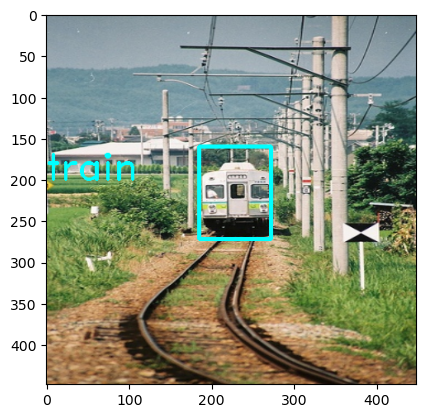

In [38]:
np_img = cv2.imread('./VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
# np_img = tf.keras.applications.densenet.preprocess_input(np_img)

np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))


y_pred = final_model(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()

## Revise process_outputs

In [39]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    # P's shape [7, 7, 2, 20]

    xmin, ymin, xmax, ymax, class_num, conf = [], [], [], [], [], []

    max_conf_idx = np.unravel_index(np.argmax(P), P.shape)
    threshold = P[max_conf_idx] * 0.5

    for i in range(np.prod(P.shape)):
        idx = np.unravel_index(i, P.shape)
        if (P[idx] > threshold):
            class_num.append(idx[3])
            conf.append(P[idx])

            coordinate = np.reshape(coordinate, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))
            xcenter, ycenter, w, h = coordinate[idx[0], idx[1], idx[2], :]

            xcenter = (idx[1] + xcenter) * (IMAGE_SIZE / float(CELL_SIZE))
            ycenter = (idx[0] + ycenter) * (IMAGE_SIZE / float(CELL_SIZE))

            w = w * IMAGE_SIZE
            h = h * IMAGE_SIZE

            xmin.append(xcenter - w / 2.0)
            ymin.append(ycenter - h / 2.0)

            xmax.append(xmin[-1] + w)
            ymax.append(ymin[-1] + h)

    return xmin, ymin, xmax, ymax, class_num, conf

In [40]:
with open('./test_prediction.txt', 'w') as fout:
    for img_name, test_img, img_h, img_w in test_dataset:
        batch_num = img_name.shape[0]
        for i in range(batch_num):
            xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
            for j in range(len(xmin)):
                xmin[j] = xmin[j] * (img_w[i] / IMAGE_SIZE)
                ymin[j] = ymin[j] * (img_h[i] / IMAGE_SIZE)
                xmax[j] = xmax[j] * (img_w[i] / IMAGE_SIZE)
                ymax[j] = ymax[j] * (img_h[i] / IMAGE_SIZE)
                fout.write(img_name[i].numpy().decode('ascii')+" %d %d %d %d %d %f\n" % (
                    xmin[j], ymin[j], xmax[j], ymax[j], class_num[j], conf[j]))

In [41]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_InceptionResnetV2_YOLO.csv')

import pandas as pd
cap = pd.read_csv('./output_file_InceptionResnetV2_YOLO.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

End Evalutation
score: 0.422873


## Xception + YOLO

In [ ]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

basemodel = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_tensor=img_inputs)
basemodel.summary()

In [ ]:
basemodel.trainable = False
x = conv_leaky_relu(basemodel.output, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

final_model = tf.keras.Model(inputs=img_inputs, outputs=outputs, name='Xception_YOLO')
final_model.summary()

In [ ]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [ ]:
dataset = DatasetGenerator().generate()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=final_model)
manager = tf.train.CheckpointManager(ckpt, './ckpts/Xception_YOLO', max_to_keep=3,
                                     checkpoint_name='Xception_YOLO')

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = final_model(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, final_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, final_model.trainable_weights))

In [ ]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

In [ ]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
ckpt = tf.train.Checkpoint(net=final_model)
ckpt.restore('./ckpts/Xception_YOLO/Xception_YOLO-40')

In [ ]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

In [ ]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_Xception.csv')

import pandas as pd
cap = pd.read_csv('./output_file_Xception.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

## ResNet50V2 + YOLO

In [ ]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
basemodel = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_tensor=img_inputs)
basemodel.summary()

In [ ]:
basemodel.trainable = False
x = conv_leaky_relu(basemodel.output, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

final_model = tf.keras.Model(inputs=img_inputs, outputs=outputs, name='ResNet50V2_YOLO')
final_model.summary()

In [ ]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [ ]:
dataset = DatasetGenerator().generate()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=final_model)
manager = tf.train.CheckpointManager(ckpt, './ckpts/ResNet50V2_YOLO', max_to_keep=3,
                                     checkpoint_name='ResNet50V2_YOLO')

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = final_model(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, final_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, final_model.trainable_weights))

In [ ]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

In [ ]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
ckpt = tf.train.Checkpoint(net=final_model)
ckpt.restore('./ckpts/ResNet50V2_YOLO/ResNet50V2_YOLO-40')

In [ ]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

In [ ]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_ResNet50V2.csv')

cap = pd.read_csv('./output_file_ResNet50V2.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

## NASNetLarge + YOLO

In [ ]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(COM_DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(
                min(len(self.record_list[-1]) // 5, MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] + \
                    [0., 0., 0., 0., 0.] * \
                    (MAX_OBJECTS_PER_IMAGE - len(self.record_list[-1]) // 5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE * 5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE * 5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(COM_IMAGE_DIR + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image = (image/255) * 2 - 1
        image = tf.keras.applications.nasnet.preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names,
                                                      np.array(self.record_list),
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)\
                         .map(self._data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                         .batch(BATCH_SIZE, drop_remainder=True)\
                         .prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

In [ ]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
basemodel = tf.keras.applications.nasnet.NASNetLarge(include_top=False, weights='imagenet', input_tensor=img_inputs)
basemodel.summary()

In [ ]:
basemodel.trainable = False
x = conv_leaky_relu(basemodel.output, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

final_model = tf.keras.Model(inputs=img_inputs, outputs=outputs, name='NASNetLarge_YOLO')
final_model.summary()

In [ ]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [ ]:
dataset = DatasetGenerator().generate()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=final_model)
manager = tf.train.CheckpointManager(ckpt, './ckpts/NASNetLarge_YOLO', max_to_keep=3,
                                     checkpoint_name='NASNetLarge_YOLO')

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = final_model(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, final_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, final_model.trainable_weights))

In [ ]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

In [ ]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
ckpt = tf.train.Checkpoint(net=final_model)
ckpt.restore('./ckpts/NASNetLarge_YOLO/NASNetLarge_YOLO-40')

In [ ]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

In [ ]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_NASNetLarge.csv')

import pandas as pd
cap = pd.read_csv('./output_file_NASNetLarge.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

## EfficientNetV2B3 + YOLO

In [ ]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
basemodel = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False, 
                                                                   weights='imagenet', 
                                                                   input_tensor=img_inputs,
                                                                   include_preprocessing=False)
basemodel.summary()

In [ ]:
basemodel.trainable = False
x = conv_leaky_relu(basemodel.output, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

In [ ]:
final_model = tf.keras.Model(inputs=img_inputs, outputs=outputs, name='EfficientNetV2B3_YOLO')
final_model.summary()

In [ ]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [ ]:
dataset = DatasetGenerator().generate()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=final_model)
manager = tf.train.CheckpointManager(ckpt, './ckpts/EfficientNetV2B3_YOLO', max_to_keep=3,
                                     checkpoint_name='EfficientNetV2B3_YOLO')

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = final_model(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, final_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, final_model.trainable_weights))

In [ ]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

In [ ]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
ckpt = tf.train.Checkpoint(net=final_model)
ckpt.restore('./ckpts/EfficientNetV2B3_YOLO/EfficientNetV2B3_YOLO-40')

In [ ]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

In [ ]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file_EfficientNetV2B3.csv')

cap = pd.read_csv('./output_file_output_file_EfficientNetV2B3.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))